In [2]:
# import all required libraries
import pandas as pd
import numpy as np

In [3]:
# to ignore write to copy warning from sklearn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
# read data from csv
portfolio_df = pd.read_csv("data/portfolio.csv")
profile_df = pd.read_csv("data/profile.csv")
transcript_df = pd.read_csv("data/transcript.csv")

del portfolio_df["Unnamed: 0"]
del profile_df["Unnamed: 0"]
del transcript_df["Unnamed: 0"]

In [5]:
portfolio_df.head()

,reward,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


In [6]:
profile_df.head()

,gender,age,id,became_member_on,income
0,F,39,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.000000
2,M,30,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65404.991568
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.000000
4,M,53,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65404.991568


In [7]:
transcript_df.head()

,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,person,value,time,value_type
0,0,1,0,0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer_id
1,0,1,0,0,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer_id
2,0,1,0,0,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,offer_id
3,0,1,0,0,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,offer_id
4,0,1,0,0,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0,offer_id


## Data Preparation

Our end goal is to predict if a user would respond and complete an offer. We want to build models that can give us a user's response class.

We will define our target user_response as belonging to 4 different classes.

> 0 - user did not make any purchase due to sent offers<br>
1 - user completed offer due to sent offer<br>
2 - user completed offer by chance (without viewing)<br>
3 - user made purchase due to information<br>

**Expectation**: Given a user's info and the offer info to our model we should be able to predict what the user response will be.

### Steps:

1. Convert duration to hours from days in portfolio data
2. Convert string id for users to numerical ids
3. Convert string id for offers to numerical ids
4. Add one-hot columns for gender in profile data
5. Convert date to year for became_member_on in profile data
6. Calculate total amount spent from transactions for each user
7. Convert offer type to one-hot in portfolio data

In [8]:
# convert duration to hours
portfolio_df["duration"] = portfolio_df["duration"].apply(lambda days: days * 24)

In [9]:
# assign numerical id for customers across all dataframes
user_id_map = {}
last_assigned_id = 0

def assign_user_id(user):
    """
    convert string user id into numerical id
    
    Args:
      - user (string): given unique string user id
      
    Return:
      - id (int): numerical id assigned to user
    """
    global last_assigned_id
    if user not in user_id_map.keys():
        last_assigned_id += 1
        user_id_map[user] = last_assigned_id  
    return user_id_map[user]

profile_df["user_id"] = profile_df["id"].apply(assign_user_id)
profile_df.head()

,gender,age,id,became_member_on,income,user_id
0,F,39,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,1
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.000000,2
2,M,30,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65404.991568,3
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.000000,4
4,M,53,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65404.991568,5


In [10]:
transcript_df["user_id"] = transcript_df["person"].apply(assign_user_id)
transcript_df.head()

,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,person,value,time,value_type,user_id
0,0,1,0,0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer_id,4
1,0,1,0,0,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer_id,5
2,0,1,0,0,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,offer_id,6
3,0,1,0,0,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,offer_id,7
4,0,1,0,0,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0,offer_id,8


In [11]:
# verify user id assigned is same across dataframes
def test_user_id(user_id):
    """
    test function to verify if user id assigned in profile data is
    assigned correctly in transcript data
    
    Args:
      - user_id (int): numerical id assigned to user
    
    Return: None
    
    Raise:
      - assertion error if wrong user ids found
    """
    old_id = profile_df[profile_df["user_id"] == user_id]["id"].values[0]
    assigned_id = transcript_df[transcript_df["person"] == old_id]["user_id"].unique().tolist()
    assert len(assigned_id) == 1, "Expect only one unique user_id, got: {}".format(assigned_id)
    assert assigned_id[0] == user_id, "Not same user id! Expected: {} Got: {}".format(user_id, assigned_id[0])


# test for random user ids
test_user_id(1)

test_user_id(10)

test_user_id(16)

# delete old ids
del profile_df["id"]
del transcript_df["person"]

In [12]:
# assign numerical id for offers across all dataframes
offer_id_map = {}
last_assigned_id = 0

def assign_offer_id(offer):
    """
    convert string offer id into numerical id
    
    Args:
      - offer (string): given unique string offer id
      
    Return:
      - id (int): numerical id assigned to offer
    """
    global last_assigned_id
    if offer not in offer_id_map.keys():
        last_assigned_id += 1
        offer_id_map[offer] = last_assigned_id  
    return offer_id_map[offer]

portfolio_df["offer_id"] = portfolio_df["id"].apply(assign_offer_id)
portfolio_df.head()

,reward,difficulty,duration,offer_type,id,web,email,mobile,social,offer_id
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,2
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,3
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,4
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,5


In [13]:
# separate transactions from offer events
transaction_df = transcript_df[transcript_df["event_transaction"] == 1]
# convert value for transactions into float
transaction_df["value"] = transaction_df["value"].astype(float)

offer_df = transcript_df[transcript_df["event_transaction"] == 0]

# replace numerical offer ids in transcript dataset
offer_df["offer_id"] = offer_df["value"].apply(assign_offer_id)
offer_df.head()

,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,value,time,value_type,user_id,offer_id
0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer_id,4,4
1,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer_id,5,5
2,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,0,offer_id,6,10
3,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,0,offer_id,7,7
4,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,offer_id,8,2


In [14]:
# verify offer id assigned is same across dataframes
def test_offer_id(offer_id):
    """
    test function to verify if offer id assigned in portfolio data is
    assigned correctly in transcript data
    
    Args:
      - offer_id (int): numerical id assigned to offer
    
    Return: None
    
    Raise:
      - assertion error if wrong offer ids found
    """
    old_id = portfolio_df[portfolio_df["offer_id"] == offer_id]["id"].values[0]
    assigned_id = offer_df[offer_df["value"] == old_id]["offer_id"].unique().tolist()
    assert len(assigned_id) == 1, "Expect only one unique user_id, got: {}".format(assigned_id)
    assert assigned_id[0] == offer_id, "Not same user id! Expected: {} Got: {}".format(user_id, assigned_id[0])


# test for random user ids
test_offer_id(1)
test_offer_id(4)
test_offer_id(7)

In [15]:
# delete old id columns
del offer_df["value"]
del offer_df["value_type"]
del portfolio_df["id"]

In [16]:
# convert gender in profile_df to one hot
profile_df = pd.concat([pd.get_dummies(profile_df["gender"], prefix="gender"), profile_df.drop(["gender"], axis=1)], axis=1)
profile_df.head()

,gender_F,gender_M,gender_O,age,became_member_on,income,user_id
0,1,0,0,39,2017-02-12,65404.991568,1
1,1,0,0,55,2017-07-15,112000.000000,2
2,0,1,0,30,2018-07-12,65404.991568,3
3,1,0,0,75,2017-05-09,100000.000000,4
4,0,1,0,53,2017-08-04,65404.991568,5


In [17]:
# covert became_member_on to became_member_year in profile_df
def get_year(date):
    """
    return year from datetime object
    
    Args:
      - date (datetime): date
      
    Return:
      - year (int): year in date
    """
    return date.year

profile_df["became_member_year"] = pd.to_datetime(profile_df["became_member_on"]).apply(get_year)
del profile_df["became_member_on"]

profile_df.head()

,gender_F,gender_M,gender_O,age,income,user_id,became_member_year
0,1,0,0,39,65404.991568,1,2017
1,1,0,0,55,112000.000000,2,2017
2,0,1,0,30,65404.991568,3,2018
3,1,0,0,75,100000.000000,4,2017
4,0,1,0,53,65404.991568,5,2017


In [18]:
# add total amount spent by each user into profile_df
user_total_amt = {}

def add_user_expendiure(row):
    """
    Calculate total amount spent by a user and store in user_total_amt
    
    Args:
      - row: transaction event entry in transcript data
    
    Return: None
    """
    if row["user_id"] in user_total_amt.keys():
        user_total_amt[row["user_id"]] += row["value"]
    user_total_amt[row["user_id"]] = row["value"]

# add values to user_total_amt
transaction_df.apply(add_user_expendiure, axis=1)

def get_user_expenditure(user_id):
    """
    Get total amount spent by user from user_total_amt.
    If no entry for user is found return 0
    
    Args:
      - user_id (int): unique numerical id for user
      
    Return:
      - total amount spent by user, if None return 0
    """
    if user_id in user_total_amt.keys():
        return user_total_amt[user_id]
    return 0

# add values from user_total_amt by each user into profile_df
profile_df["total_amt"] = profile_df["user_id"].apply(get_user_expenditure)
profile_df.head()

,gender_F,gender_M,gender_O,age,income,user_id,became_member_year,total_amt
0,1,0,0,39,65404.991568,1,2017,5.21
1,1,0,0,55,112000.000000,2,2017,23.22
2,0,1,0,30,65404.991568,3,2018,4.09
3,1,0,0,75,100000.000000,4,2017,26.56
4,0,1,0,53,65404.991568,5,2017,0.06


In [19]:
# convert offer_type to one hot in portfolio_df
portfolio_df = pd.concat([pd.get_dummies(portfolio_df["offer_type"], prefix="offer_type"), portfolio_df.drop(["offer_type"], axis=1)], axis=1)
portfolio_df.head()

,offer_type_bogo,offer_type_discount,offer_type_informational,reward,difficulty,duration,web,email,mobile,social,offer_id
0,1,0,0,10,10,168,0,1,1,1,1
1,1,0,0,10,10,120,1,1,1,1,2
2,0,0,1,0,0,96,1,1,1,0,3
3,1,0,0,5,5,168,1,1,1,0,4
4,0,1,0,5,20,240,1,1,0,0,5


Combine received and completed events in offer_df and assign response class to each from below

- class 0: user did not make any purchase due to sent offers
- class 1: user completed offer due to sent offer
- class 2: user completed offer by chance (without viewing)
- class 3: user made purchase due to information

### _Algorithm for assigning offer response_:
    
1.   > for every non informational offer received:
           if there is an entry for that offer completion within/with the time offer received + duration of offer
               mark offer_completion as accounted
               if offer_viewed
                    completion_time = completed_time - viewed_time
                    assign offer_response = 1
               else:
                    completion_time = offer duration
                    assign offer_response = 2
           else if there is no offer_completion
               completion_time = 0
               assign offer_response = 0


2.   > for every offer completed
         if not accounted
             completion_time = offer duration
             assign offer_response = 2


3.   > for every informational offer received
          if offer_viewed:
              if there is/are transactions within/with the time offer received + duration of offer
                  completion_time = first_transaction_time - viewed_time
                  assign offer_response = 3
          else:
              completion_time = 0
              assign offer_response = 0

## Algorithm #1

In [20]:
# select non informational offers
information_df = portfolio_df[portfolio_df.offer_type_informational == 1]
non_information_df = portfolio_df[portfolio_df.offer_type_informational != 1]

information_offer_ids = information_df["offer_id"].tolist()
print("Informational offer ids:", information_offer_ids)
# non information offer events
non_info_trans_df = offer_df[~offer_df["offer_id"].isin(information_offer_ids)]

# received events in non_info_trans_df
received_df = non_info_trans_df[non_info_trans_df["event_offer_received"] == 1]

# completed events in non_info_trans_df
completed_df = non_info_trans_df[non_info_trans_df["event_offer_completed"] == 1]

# viewed events in non_info_trans_df
viewed_df = non_info_trans_df[non_info_trans_df["event_offer_viewed"] == 1]

Informational offer ids: [3, 8]


In [21]:
completed_df["accounted"] = 0
received_df["completion_time"] = 0

In [22]:
def get_offer_duration(offer_id):
    """
    Get the duration for offer
    
    Args:
      - offer_id(int): unique id for offer
    
    Return:
      - time (int): hours the offer is valid
    """
    return portfolio_df[portfolio_df["offer_id"] == offer_id]["duration"].values[0]

def get_completed_row(user_id, offer_id, start_time, expiry_time):
    """
    Return the first row with offer completed time after offer received
    and withing offer expire time
    
    Args:
      - user_id (int): unique user id
      - offer_id (int): unique offer id
      - start_time (int): hour when the offer was received by user
      - expiry_time (int): hour when offer will go invalid for user
      
    Return:
      - row: first offer completed row with user_id and time within start and expire
    """
    user_offer = completed_df[(completed_df.user_id == user_id) & (completed_df.offer_id == offer_id)]
    if user_offer.shape[0] > 0:
        ret_df = user_offer[(user_offer.time > start_time) & (user_offer.time <= expiry_time)]
        if ret_df.shape[0] > 0:
            return ret_df.sort_values("time").iloc[0]
    return None

def get_viewed_row(user_id, offer_id, start_time, expiry_time):
    """
    Return the first row with offer viewed time after offer received
    and withing offer expire time
    
    Args:
      - user_id (int): unique user id
      - offer_id (int): unique offer id
      - start_time (int): hour when the offer was received by user
      - expiry_time (int): hour when offer will go invalid for user
      
    Return:
      - row: first offer viewed row with user_id and time within start and expire
    """
    user_offer = viewed_df[(viewed_df.user_id == user_id) & (viewed_df.offer_id == offer_id)]
    if user_offer.shape[0] > 0:
        ret_df = user_offer[(user_offer.time > start_time) & (user_offer.time < expiry_time)]
        if ret_df.shape[0] > 0:
            return ret_df.sort_values("time").iloc[0]
    return None
    
def get_offer_response(row):
    """
    Implementation of algorithm 1. For each non informational
    offer received event find a user response class.
    
    Also store time taken by user to complete the offer.
    
    Args:
      - row: offer received entry in transcript data
      
    Return:
      - user_response (int): 0, 1 or 2
    """
    # offer_id in event
    offer_id = row["offer_id"]
    
    # duration for offer in event
    offer_duration = get_offer_duration(offer_id)
    
    # offer expire time with start time at offer received
    expiry_time = row["time"] + offer_duration
    
    # user_id in event
    user_id = row["user_id"]
    
    # get the first completed entry for offer by user within expire time
    completed_row = get_completed_row(user_id, offer_id, row["time"], expiry_time)
    if completed_row is not None:
        completed_df.loc[completed_row.name, "accounted"] = 1
        
        # check if the completed offer was viewed before completion
        viewed_row = get_viewed_row(user_id, offer_id, row["time"], expiry_time)
        if viewed_row is not None:
            received_df.loc[row.name, "completion_time"] = abs(completed_row["time"] - viewed_row["time"])
            return 1
        else:
            # as it is by chance that user completed offer it completion time could be any time of offer duration
            received_df.loc[row.name, "completion_time"] = offer_duration
            return 2
    else:
        # if offer is not completed then the user did not respond to offer return response as 0
        received_df.loc[row.name, "completion_time"] = 0
        return 0

In [23]:
received_df["offer_response"] = received_df.apply(get_offer_response, axis=1)
received_df.head()

,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,time,user_id,offer_id,completion_time,offer_response
0,0,1,0,0,0,4,4,126,1
1,0,1,0,0,0,5,5,0,0
2,0,1,0,0,0,6,10,0,0
3,0,1,0,0,0,7,7,0,0
4,0,1,0,0,0,8,2,0,0


## Algorithm #2

In [24]:
# not accounted completions
print("Offers completed by chance / not due to sent offer:", completed_df[completed_df["accounted"] == 0].shape[0])

not_accounted = completed_df[completed_df["accounted"] == 0]
not_accounted["offer_response"] = 2
not_accounted["completion_time"] = not_accounted["offer_id"].apply(get_offer_duration)
not_accounted.head()

Offers completed by chance / not due to sent offer: 2493


,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,time,user_id,offer_id,accounted,offer_response,completion_time
12658,1,0,0,0,0,56,10,0,2,168
12672,1,0,0,0,0,152,7,0,2,240
12679,1,0,0,0,0,175,4,0,2,168
12692,1,0,0,0,0,300,1,0,2,168
12697,1,0,0,0,0,317,2,0,2,120


In [25]:
# remove accounted column from not_accounted df
del not_accounted["accounted"]

# concat received_df and not_accounted
model_df = pd.concat([received_df, not_accounted], axis=0)

## Algorithm #3

the user transaction could also be for a offer but there is no way confirming this as transactions don't have offer_id

In [26]:
# information offer transactions
info_trans_df = offer_df[offer_df["offer_id"].isin(information_offer_ids)]

# received events in info_trans_df
info_received_df = info_trans_df[info_trans_df["event_offer_received"] == 1]

# viewed events in non_info_trans_df
# in get_offer_response defined we use old defined method get_viewed_row which uses viewed_df for non_info_trans_df
# hence redifining with same name
viewed_df = info_trans_df[info_trans_df["event_offer_viewed"] == 1]

info_received_df["completion_time"] = 0

In [27]:
def get_transaction_row(user_id, start_time, expiry_time):
    """
    Return the first transaction row for user with time after
    offer received and withing offer expire time
    
    Args:
      - user_id (int): unique user id
      - start_time (int): hour when the offer was received by user
      - expiry_time (int): hour when offer will go invalid for user
      
    Return:
      - row: first transaction row with user_id and time within start and expire
    """
    user_offer = transaction_df[(transaction_df.user_id == user_id)]
    if user_offer.shape[0] > 0:
        ret_df = user_offer[(user_offer.time > start_time) & (user_offer.time < expiry_time)]
        if ret_df.shape[0] > 0:
            return ret_df.sort_values("time").iloc[0]
    return None

def get_offer_response(row):
    """
    Implementation of algorithm 3. For each informational offer
    received event find a user response class.
    
    Also store time taken by user to complete the offer.
    
    Args:
      - row: offer received entry in transcript data
      
    Return:
      - user_response (int): 0 or 3
    """
    # offer_id in event
    offer_id = row["offer_id"]
    
    # duration for offer in event
    offer_duration = get_offer_duration(offer_id)
    
    # offer expire time with start time at offer received
    expiry_time = row["time"] + offer_duration
    
    # user_id in event
    user_id = row["user_id"]
    
    viewed_row = get_viewed_row(user_id, offer_id, row["time"], expiry_time)
    if viewed_row is not None:
        # get the first transaction entry for offer by user within expire time
        transaction_row = get_transaction_row(user_id, row["time"], expiry_time)
        if transaction_row is not None:
            info_received_df.loc[row.name, "completion_time"] = abs(transaction_row["time"] - viewed_row["time"])
            return 3
    # if offer is not viewed then the user did not respond to offer return response as 0
    info_received_df.loc[row.name, "completion_time"] = 0
    return 0

In [28]:
info_received_df["offer_response"] = info_received_df.apply(get_offer_response, axis=1)
info_received_df.head()

,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,time,user_id,offer_id,completion_time,offer_response
7,0,1,0,0,0,13,3,0,0
13,0,1,0,0,0,23,3,0,3
31,0,1,0,0,0,49,8,0,0
44,0,1,0,0,0,67,8,18,3
53,0,1,0,0,0,83,8,0,3


In [29]:
# concat info_received_df and model_df
model_df = pd.concat([info_received_df, model_df], axis=0)

In [30]:
# delete event type and time columns
del model_df["event_offer_completed"]
del model_df["event_offer_viewed"]
del model_df["event_transaction"]
del model_df["event_offer_received"]
del model_df["time"]

In [31]:
# add reward, difficulty and offer duration to model_df based on offer_id
offer_data = portfolio_df[["offer_id", "reward", "duration", "difficulty"]].set_index("offer_id")
model_df = model_df.join(offer_data, on="offer_id")

In [32]:
# add user data to model_df
model_df = model_df.join(profile_df.set_index("user_id"), on="user_id")

In [33]:
print("Percentage of transactions due to sent offer:", model_df[model_df["offer_response"] == 1].shape[0]/ model_df.shape[0])

Percentage of transactions due to sent offer: 0.26244763234734036


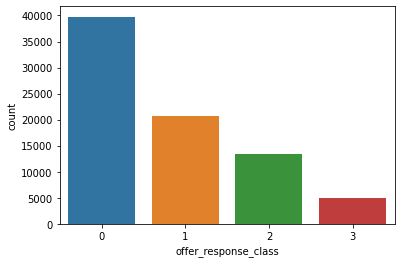

In [34]:
import seaborn as sns

response_counts = model_df.offer_response.value_counts().reset_index()
ax = sns.barplot(x='index', y='offer_response', data=response_counts);
ax.set(xlabel="offer_response_class", ylabel="count");

**Distribution of target variable after data preparation**

We have a unbalanced data for our model from the above plot. This cause an issue while evaluating model performances. In such cases using **accuracy** is not best suited as the models will predict more data points to class 0 to get a many right.

We will user SMOTE for data over-sampling to balance this later.

In [35]:
print("Data for ML model")
print("Rows:", model_df.shape[0], model_df.shape[1])
model_df.head()

Data for ML model
Rows: 78770 14


,user_id,offer_id,completion_time,offer_response,reward,duration,difficulty,gender_F,gender_M,gender_O,age,income,became_member_year,total_amt
7,13,3,0,0,0,96,0,0,1,0,58,51000.0,2017,0.87
13,23,3,0,3,0,96,0,1,0,0,78,71000.0,2017,18.98
31,49,8,0,0,0,72,0,0,1,0,39,51000.0,2014,1.63
44,67,8,18,3,0,72,0,0,1,0,75,52000.0,2015,6.86
53,83,8,0,3,0,72,0,0,1,0,27,35000.0,2018,3.62


In [36]:
# separate dependent and independent variables for machine learning models
X_df = model_df.drop(["offer_response"], axis=1)
X_df.head()

,user_id,offer_id,completion_time,reward,duration,difficulty,gender_F,gender_M,gender_O,age,income,became_member_year,total_amt
7,13,3,0,0,96,0,0,1,0,58,51000.0,2017,0.87
13,23,3,0,0,96,0,1,0,0,78,71000.0,2017,18.98
31,49,8,0,0,72,0,0,1,0,39,51000.0,2014,1.63
44,67,8,18,0,72,0,0,1,0,75,52000.0,2015,6.86
53,83,8,0,0,72,0,0,1,0,27,35000.0,2018,3.62


In [39]:
# create average completion_time for each user, offer pair
compl_time_df = X_df[["user_id", "offer_id", "completion_time"]].groupby(["user_id", "offer_id"]).mean().reset_index()
compl_time_df.to_csv("app/data/completion.csv")

In [40]:
# save user and portfolio data for web app queries
offer_data.to_csv("app/data/portfolio.csv")
profile_df.to_csv("app/data/profile.csv")

In [42]:
profile_df["user_id"].max()

17000

In [37]:
# save prepared data
X_df.to_csv("data/processed/data.csv")
model_df["offer_response"].to_csv("data/processed/target.csv")